# Hierarchically Deep Convolutional Neural Network For Architecture Image Recognition

## Setup and Imports

**Import Packages**

In [ ]:
import keras as kr
import numpy as np
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

from sklearn.model_selection import train_test_split

from random import randint
import time
import os

In [ ]:
if not os.path.exists('data/models/'):
    os.mkdir('data/models')

**Define Global Variables**

In [ ]:
# The number of coarse categories
coarse_categories = 9

# The number of fine categories
fine_categories = 21

## Import and Preprocess Dataset

In [ ]:
import random
import keras_preprocessing.image

def load_and_crop_img(path, grayscale=False, color_mode='rgb', target_size=None,
             interpolation='nearest'):
    """Wraps keras_preprocessing.image.utils.loag_img() and adds cropping.
    Cropping method enumarated in interpolation
    # Arguments
        path: Path to image file.
        color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
            The desired image format.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation and crop methods used to resample and crop the image
            if the target size is different from that of the loaded image.
            Methods are delimited by ":" where first part is interpolation and second is crop
            e.g. "lanczos:random".
            Supported interpolation methods are "nearest", "bilinear", "bicubic", "lanczos",
            "box", "hamming" By default, "nearest" is used.
            Supported crop methods are "none", "center", "random".
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """

    # Decode interpolation string. Allowed Crop methods: none, center, random
    interpolation, crop = interpolation.split(":") if ":" in interpolation else (interpolation, "none")  

    if crop == "none":
        return keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=target_size,
                                            interpolation=interpolation)

    # Load original size image using Keras
    img = keras_preprocessing.image.utils.load_img(path, 
                                            grayscale=grayscale, 
                                            color_mode=color_mode, 
                                            target_size=None, 
                                            interpolation=interpolation)

    # Crop fraction of total image
    crop_fraction = 0.875
    target_width = target_size[1]
    target_height = target_size[0]

    if target_size is not None:        
        if img.size != (target_width, target_height):

            if crop not in ["center", "random"]:
                raise ValueError('Invalid crop method {} specified.', crop)

            if interpolation not in keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(interpolation,
                        ", ".join(keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS.keys())))
            
            resample = keras_preprocessing.image.utils._PIL_INTERPOLATION_METHODS[interpolation]

            width, height = img.size

            # Resize keeping aspect ratio
            # result shold be no smaller than the targer size, include crop fraction overhead
            target_size_before_crop = (target_width/crop_fraction, target_height/crop_fraction)
            ratio = max(target_size_before_crop[0] / width, target_size_before_crop[1] / height)
            target_size_before_crop_keep_ratio = int(width * ratio), int(height * ratio)
            img = img.resize(target_size_before_crop_keep_ratio, resample=resample)

            width, height = img.size

            if crop == "center":
                left_corner = int(round(width/2)) - int(round(target_width/2))
                top_corner = int(round(height/2)) - int(round(target_height/2))
                return img.crop((left_corner, top_corner, left_corner + target_width, top_corner + target_height))
            elif crop == "random":
                left_shift = random.randint(0, int((width - target_width)))
                down_shift = random.randint(0, int((height - target_height)))
                return img.crop((left_shift, down_shift, target_width + left_shift, target_height + down_shift))

    return img
  
keras_preprocessing.image.iterator.load_img = load_and_crop_img

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
fine_datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    rotation_range=20,
    horizontal_flip=True,
    samplewise_std_normalization = True)
fine_dir = "/content/drive/MyDrive/CS135_final_data/fine"
fine_img = fine_datagen.flow_from_directory(fine_dir,target_size=(64,64), batch_size=128, interpolation = 'lanczos:center')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 8380 images belonging to 21 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tqdm import tqdm
fine_img.reset()
X_fine, y_fine = next(fine_img)
for i in tqdm(range(int(len(fine_img))-1)): #1st batch is already fetched before the for loop.
  img, label = next(fine_img)
  X_fine = np.append(X_fine, img, axis=0)
  y_fine = np.append(y_fine, label, axis=0)
print(X_fine.shape, y_fine.shape)

100%|██████████| 65/65 [01:50<00:00,  1.70s/it]

(8380, 64, 64, 3) (8380, 21)


**Fine-To-Coarse Mapping**

(Ideally, this would be done through spectral clustering as opposed to hard-coding)

In [ ]:
fine2coarse = np.zeros((fine_categories,coarse_categories))
fine2coarse[0,0] = 1
fine2coarse[1,5] = 1
fine2coarse[2,5] = 1
fine2coarse[3,0] = 1
fine2coarse[4,5] = 1
fine2coarse[5,5] = 1
fine2coarse[6,3] = 1
fine2coarse[7,6] = 1
fine2coarse[8,4] = 1
fine2coarse[9,2] = 1
fine2coarse[10,5] = 1
fine2coarse[11,8] = 1
fine2coarse[12,5] = 1
fine2coarse[13,2] = 1
fine2coarse[14,6] = 1
fine2coarse[15,7] = 1
fine2coarse[16,3] = 1
fine2coarse[17,8] = 1
fine2coarse[18,5] = 1
fine2coarse[19,1] = 1
fine2coarse[20,6] = 1
# fine2coarse[21,4] = 1
# fine2coarse[22,1] = 1
# fine2coarse[23,4] = 1
# fine2coarse[24,4] = 1

In [ ]:
# with np.printoptions(threshold=np.inf):
#     print(fine2coarse)

**Split Training set into Training and Validation sets**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_fine, y_fine, test_size=.2,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


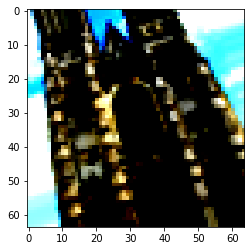

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13]


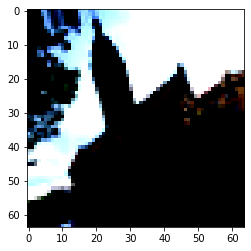

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


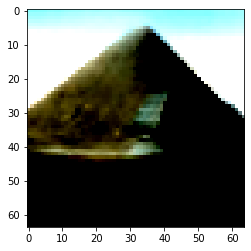

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3]


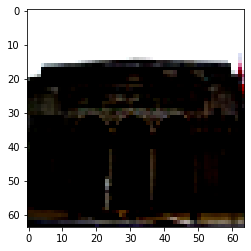

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4]


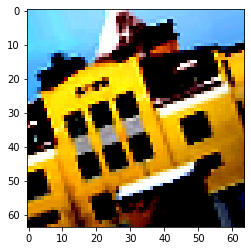

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


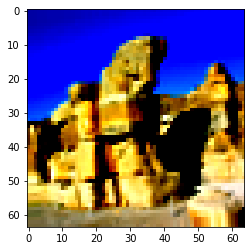

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


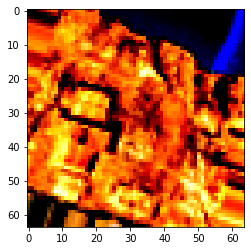

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


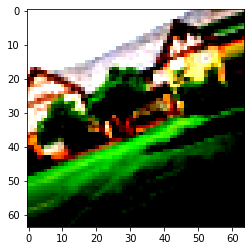

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20]


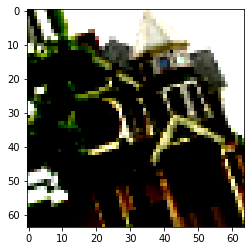

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18]


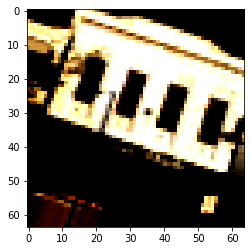

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[10]


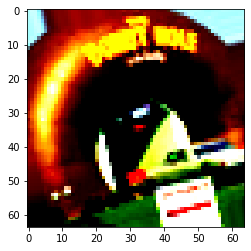

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13]


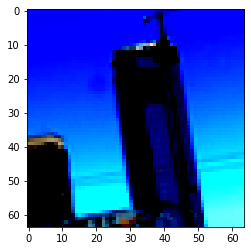

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


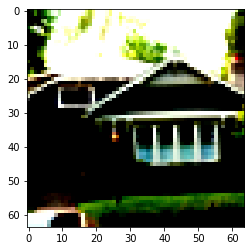

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3]


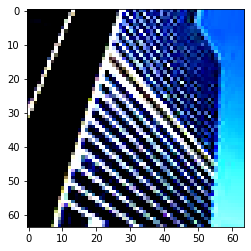

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4]


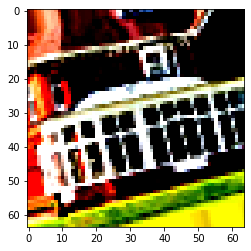

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[5]


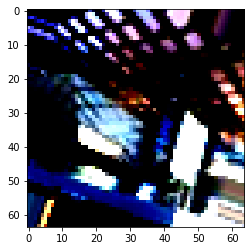

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


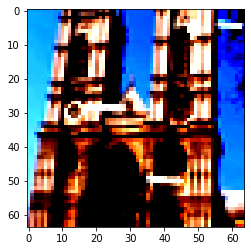

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0]


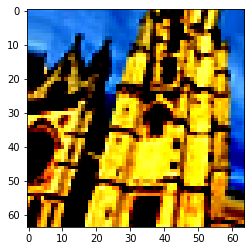

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[20]


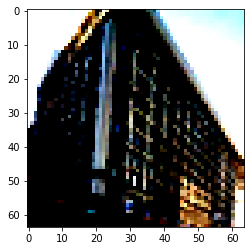

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[18]


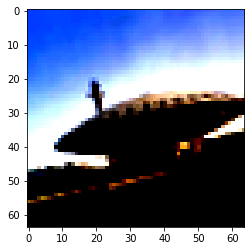

[10]


In [ ]:
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

for i in range(0,10):
    image = x_train[i]
    plt.imshow(image)
    plt.show()
    print(np.where(y_train[i] == 1)[0])


for i in range(0,10):
    image = x_val[i]
    plt.imshow(image)
    plt.show()
    print(np.where(y_train[i] == 1)[0])

In [ ]:
# y_fine_eight = y_fine[np.argwhere(y_fine==1)[:,1] < 8]
# X_fine_eight = X_fine[np.argwhere(y_fine==1)[:,1] < 8]
# x_train_eight, x_val_eight, y_train_eight, y_val_eight = train_test_split(X_fine_eight, y_fine_eight, test_size=.1,shuffle=True)

**Constructing CNN**

In [ ]:
from keras import optimizers
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.models import Model

in_layer = Input(shape=(64, 64, 3), dtype='float32', name='main_input')

net = Conv2D(64, 3, strides=1, padding='same', activation='relu')(in_layer)
net = BatchNormalization()(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(128, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
# net = Dropout(.3)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(256, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
# net = Dropout(.4)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(net)
net = BatchNormalization()(net)
# net = Dropout(.5)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Flatten()(net)

net = Dense(1024, activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
net = Dense(21, activation='softmax')(net)

**Compile Model**

In [ ]:
model = Model(inputs=in_layer,outputs=net)
adam_coarse = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= adam_coarse, loss='categorical_crossentropy', metrics=['accuracy'])
tbCallBack = kr.callbacks.TensorBoard(log_dir='./data/graph/relu_drop/', histogram_freq=0, write_graph=True, write_images=True)

**Train Model**

In [ ]:
batch = 32

In [ ]:
index= 0
step = 5
stop = 20


while index < stop:
    model.fit(x_train, y_train, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val), callbacks=[tbCallBack])
    index += step
    model.save_weights('data/models/model_coarse'+str(index))

save_index = index

Train on 6704 samples, validate on 1676 samples
Epoch 1/5
6688/6704 [============================>.] - ETA: 0s - loss: 3.0790 - acc: 0.1785

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6704/6704 [==============================] - 5s 779us/sample - loss: 3.0766 - acc: 0.1790 - val_loss: 6.4501 - val_acc: 0.0823
Epoch 2/5
6704/6704 [==============================] - 4s 616us/sample - loss: 2.5363 - acc: 0.2736 - val_loss: 2.6565 - val_acc: 0.2625
Epoch 3/5
6704/6704 [==============================] - 4s 619us/sample - loss: 2.1517 - acc: 0.3571 - val_loss: 2.3405 - val_acc: 0.3126
Epoch 4/5
6704/6704 [==============================] - 4s 624us/sample - loss: 1.8021 - acc: 0.4503 - val_loss: 2.2758 - val_acc: 0.3431
Epoch 5/5
6704/6704 [==============================] - 4s 627us/sample - loss: 1.4956 - acc: 0.5336 - val_loss: 2.4094 - val_acc: 0.3598
Train on 6704 samples, validate on 1676 samples
Epoch 6/10
6704/6704 [==============================] - 4s 627us/sample - loss: 1.1733 - acc: 0.6207 - val_loss: 2.3746 - val_acc: 0.3640
Epoch 7/10
6704/6704 [==============================] - 4s 623us/sample - loss: 0.8634 - acc: 0.7240 - val_loss: 2.5087 - val_acc: 0.3717
E

In [ ]:
# index= 0
# step = 5
# stop = 40
# batch = 64
# while index < stop:
#     model.fit(x_train_eight, y_train_eight, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val_eight, y_val_eight), callbacks=[tbCallBack])
#     index += step
#     model.save_weights('data/models/model_coarse'+str(index))
# save_index = index

### construct fine optimizer

In [ ]:
adam_fine =  tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
for i in range(len(model.layers)):
    model.layers[i].trainable=False

## Fine-Tuning for Coarse Classifier

In [ ]:
y_train_c = np.dot(y_train,fine2coarse)
y_val_c = np.dot(y_val,fine2coarse)

In [ ]:
net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(model.layers[-9].output)
net = BatchNormalization()(net)
# net = Dropout(.5)(net)
net = MaxPooling2D((2, 2), padding='valid')(net)

net = Flatten()(net)

net = Dense(1024, activation='relu')(net)
net = BatchNormalization()(net)
net = Dropout(.3)(net)
out_coarse = Dense(9, activation='softmax')(net)

model_c = Model(inputs=in_layer,outputs=out_coarse)
model_c.compile(optimizer= adam_coarse, loss='categorical_crossentropy', metrics=['accuracy'])

for i in range(len(model_c.layers)-1):
    model_c.layers[i].set_weights(model.layers[i].get_weights())

In [ ]:
index = 30
step = 10
stop = 40

while index < stop:
    model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 6704 samples, validate on 1676 samples
Epoch 31/40
6704/6704 [==============================] - ETA: 0s - loss: 1.5483 - acc: 0.5358

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6704/6704 [==============================] - 3s 436us/sample - loss: 1.5483 - acc: 0.5358 - val_loss: 1.8486 - val_acc: 0.5131
Epoch 32/40
6704/6704 [==============================] - 2s 336us/sample - loss: 0.6331 - acc: 0.7779 - val_loss: 1.6208 - val_acc: 0.5334
Epoch 33/40
6704/6704 [==============================] - 2s 336us/sample - loss: 0.2537 - acc: 0.9145 - val_loss: 1.7741 - val_acc: 0.5758
Epoch 34/40
6704/6704 [==============================] - 2s 337us/sample - loss: 0.1159 - acc: 0.9655 - val_loss: 1.9517 - val_acc: 0.5811
Epoch 35/40
6704/6704 [==============================] - 2s 338us/sample - loss: 0.0501 - acc: 0.9881 - val_loss: 2.2514 - val_acc: 0.5692
Epoch 36/40
6704/6704 [==============================] - 2s 338us/sample - loss: 0.0337 - acc: 0.9925 - val_loss: 2.2748 - val_acc: 0.5788
Epoch 37/40
6704/6704 [==============================] - 2s 339us/sample - loss: 0.0197 - acc: 0.9967 - val_loss: 2.4821 - val_acc: 0.5668
Epoch 38/40
6704/6704 [================

In [ ]:
model_c.compile(optimizer= adam_fine, loss='categorical_crossentropy', metrics=['accuracy'])
stop = 50

while index < stop:
    model_c.fit(x_train, y_train_c, batch_size=batch, initial_epoch=index, epochs=index+step, validation_data=(x_val, y_val_c), callbacks=[tbCallBack])
    index += step

Train on 6704 samples, validate on 1676 samples
Epoch 41/50
6688/6704 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9849

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6704/6704 [==============================] - 3s 443us/sample - loss: 0.0490 - acc: 0.9848 - val_loss: 2.9414 - val_acc: 0.5603
Epoch 42/50
6704/6704 [==============================] - 2s 337us/sample - loss: 0.0568 - acc: 0.9820 - val_loss: 3.1512 - val_acc: 0.5412
Epoch 43/50
6704/6704 [==============================] - 2s 337us/sample - loss: 0.0685 - acc: 0.9764 - val_loss: 3.2187 - val_acc: 0.5424
Epoch 44/50
6704/6704 [==============================] - 2s 339us/sample - loss: 0.0574 - acc: 0.9821 - val_loss: 3.1738 - val_acc: 0.5477
Epoch 45/50
6704/6704 [==============================] - 2s 337us/sample - loss: 0.0669 - acc: 0.9757 - val_loss: 3.1601 - val_acc: 0.5609
Epoch 46/50
6704/6704 [==============================] - 2s 336us/sample - loss: 0.0663 - acc: 0.9775 - val_loss: 3.4419 - val_acc: 0.5340
Epoch 47/50
6704/6704 [==============================] - 2s 337us/sample - loss: 0.0519 - acc: 0.9824 - val_loss: 3.3360 - val_acc: 0.5632
Epoch 48/50
6704/6704 [================

## Fine-Tuning for Fine Classifiers

### Construct Fine Classifiers

In [ ]:
def fine_model():

    net = Conv2D(512, 3, strides=1, padding='same', activation='relu')(model.layers[-9].output)
    net = BatchNormalization()(net)
    net = MaxPooling2D((2, 2), padding='valid')(net)

    net = Flatten()(net)

    net = Dense(1024, activation='relu')(net)
    net = BatchNormalization()(net)
    net = Dropout(.3)(net)
    out_fine = Dense(21, activation='softmax')(net)


    model_fine = Model(inputs=in_layer,outputs=out_fine)
    model_fine.compile(optimizer= adam_coarse,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    for i in range(len(model_fine.layers)-1):
        model_fine.layers[i].set_weights(model.layers[i].get_weights())
    return model_fine

In [ ]:
fine_models = {'models' : [{} for i in range(coarse_categories)], 'yhf' : [{} for i in range(coarse_categories)]}
for i in range(coarse_categories):
    model_i = fine_model()
    fine_models['models'][i] = model_i

### Train Fine Classifiers on Respective Data

In [ ]:
def get_error(y,yh):
    # Threshold 
    yht = np.zeros(np.shape(yh))
    yht[np.arange(len(yh)), yh.argmax(1)] = 1
    # Evaluate Error
    error = np.count_nonzero(np.count_nonzero(y-yht,1))/len(y)
    return error

In [ ]:
for i in range(coarse_categories):
    index= 0
    step = 5
    stop = 5
    
    # Get all training data for the coarse category
    ix = np.where([(y_train[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_tix = x_train[ix]
    y_tix = y_train[ix]
    
    # Get all validation data for the coarse category
    ix_v = np.where([(y_val[:,j]==1) for j in [k for k, e in enumerate(fine2coarse[:,i]) if e != 0]])[1]
    x_vix = x_val[ix_v]
    y_vix = y_val[ix_v]
    
    while index < stop:
        fine_models['models'][i].fit(x_tix, y_tix, batch_size=16, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
        index += step
    
    # fine_models['models'][i].compile(optimizer=adam_fine, loss='categorical_crossentropy', metrics=['accuracy'])
    # stop = 10

    # while index < stop:
    #     fine_models['models'][i].fit(x_tix, y_tix, batch_size=16, initial_epoch=index, epochs=index+step, validation_data=(x_vix, y_vix))
    #     index += step
        
    yh_f = fine_models['models'][i].predict(x_val[ix_v], batch_size=batch)
    print('Fine Classifier '+str(i)+' Error: '+str(get_error(y_val[ix_v],yh_f))) 

Train on 639 samples, validate on 159 samples
Epoch 1/5
639/639 [==============================] - ETA: 0s - loss: 1.1716 - acc: 0.7778

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


639/639 [==============================] - 1s 2ms/sample - loss: 1.1716 - acc: 0.7778 - val_loss: 29.3461 - val_acc: 0.0000e+00
Epoch 2/5
639/639 [==============================] - 0s 524us/sample - loss: 0.3171 - acc: 0.9030 - val_loss: 6.7514 - val_acc: 0.3333
Epoch 3/5
639/639 [==============================] - 0s 522us/sample - loss: 0.1669 - acc: 0.9515 - val_loss: 1.2031 - val_acc: 0.7925
Epoch 4/5
639/639 [==============================] - 0s 540us/sample - loss: 0.0553 - acc: 0.9797 - val_loss: 1.2653 - val_acc: 0.7925
Epoch 5/5
639/639 [==============================] - 0s 525us/sample - loss: 0.0512 - acc: 0.9859 - val_loss: 1.4001 - val_acc: 0.7107


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Fine Classifier 0 Error: 0.2893081761006289
Train on 239 samples, validate on 62 samples
Epoch 1/5
239/239 [==============================] - 1s 4ms/sample - loss: 1.8342 - acc: 0.5105 - val_loss: 8.0078 - val_acc: 0.0968
Epoch 2/5
239/239 [==============================] - 0s 587us/sample - loss: 0.2697 - acc: 0.9331 - val_loss: 23.2436 - val_acc: 0.0000e+00
Epoch 3/5
239/239 [==============================] - 0s 563us/sample - loss: 9.7814e-04 - acc: 1.0000 - val_loss: 14.7358 - val_acc: 0.0645
Epoch 4/5
239/239 [==============================] - 0s 548us/sample - loss: 6.9678e-05 - acc: 1.0000 - val_loss: 6.1734 - val_acc: 0.3710
Epoch 5/5
239/239 [==============================] - 0s 565us/sample - loss: 1.4008e-05 - acc: 1.0000 - val_loss: 2.0905 - val_acc: 0.6774
Fine Classifier 1 Error: 0.3225806451612903
Train on 529 samples, validate on 118 samples
Epoch 1/5
529/529 [==============================] - 1s 2ms/sample - loss: 1.0286 - acc: 0.7902 - val_loss: 28.1610 - val_acc: 0.0

## Evaluate HDCNN

In [ ]:
def evaluate(X, y):
    yh = np.zeros(np.shape(y))
    
    yh_s = model.predict(X, batch_size=batch)
    
    print('Single Classifier Error: '+str(get_error(y,yh_s)))
    
    yh_c = model_c.predict(X, batch_size=batch)
    y_c = np.dot(y,fine2coarse)
    
    print('Coarse Classifier Error: '+str(get_error(y_c,yh_c)))

    for i in range(coarse_categories):
        fine_models['yhf'][i] = fine_models['models'][i].predict(X, batch_size=batch)
        
        yh += np.multiply(yh_c[:,i].reshape((len(y)),1), fine_models['yhf'][i])
    
    print('Overall Error: '+str(get_error(y,yh)))
    return yh

In [ ]:
yh = evaluate(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Single Classifier Error: 0.6700477326968973
Coarse Classifier Error: 0.4373508353221957
Overall Error: 0.6384248210023866
